## 1 환경설정

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:80% !important;}</style>"))
%matplotlib inline

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import warnings
import folium
import folium.plugins
import requests
import json
import folium.plugins
from IPython.display import Image
warnings.filterwarnings('ignore')

mpl.rcParams['figure.figsize'] = (12,8)  #시각화 figure default 설정
mpl.rcParams['font.family'] = 'NanumGothic' #폰트 디폴트 설정
mpl.rcParams['font.size'] = 10    #폰트 사이즈 디폴트 설정
plt.rcParams['axes.unicode_minus'] = False
%config InlineBackend.figure_format='retina' # 그래프 글씨 뚜렷
pd.options.display.float_format = '{:.0f}'.format # 넘파이 과학적 표기 제거

In [2]:
# 부산 행정구역 json raw파일(githubcontent)
r = requests.get('https://raw.githubusercontent.com/raqoon886/Local_HangJeongDong/master/hangjeongdong_%EB%B6%80%EC%82%B0%EA%B4%91%EC%97%AD%EC%8B%9C.geojson')
c = r.content
busan_geo = json.loads(c)

## 2 데이터 분석

### 2.1 부산광역시_부산명소정보

In [3]:
url = 'http://apis.data.go.kr/6260000/AttractionService/getAttractionKr'
params ={'serviceKey' : 'BQLLeF2hdIs7v4c0bchpT0YyP005ULdW6/wUX8rg70BY/c940AN5ss1zHbXpjWzvUCX8ZkiG0u4dfP9H39jGpA==', 
         'numOfRows' : '4000', 
         'pageNo' : '1',
         'resultType' : 'json' }

response = requests.get(url, params=params)
contents = response.content

In [4]:
json_attraction = json.loads(contents)
json_attraction

body = json_attraction['getAttractionKr']['item']
df_busan_attraction = pd.json_normalize(body)
df_busan_attraction.head(1)

UC_SEQ MAIN_TITLE GUGUN_NM  LAT  LNG    PLACE              TITLE  \
0     255    흰여울문화마을      영도구   35  129  흰여울문화마을  가파른 절벽 끝에 흰여울문화마을   

           SUBTITLE           ADDR1     CNTCT_TEL  \
0  흰여울길에서 만난 느림의 미학  부산광역시 영도구 흰여울길  051-419-4067   

                                      HOMEPAGE_URL  \
0  http://www.ydculture.com/huinnyeoulculturetown/   

                                           TRFC_INFO USAGE_DAY HLDY_INFO  \
0  도시철도 1호선 남포역 6번 출구 → 7, 71, 508 버스 환승 → 영선동 백련...                       

  USAGE_DAY_WEEK_AND_TIME USAGE_AMOUNT  \
0                      매일           무료   

                                     MIDDLE_SIZE_RM1  \
0  점보버스 휠체어 리프트 장착 차량 운행, 요금 할인 50%, 장애인 주차장(절영해안...   

                                     MAIN_IMG_NORMAL  \
0  https://www.visitbusan.net/uploadImgs/files/cn...   

                                      MAIN_IMG_THUMB  \
0  https://www.visitbusan.net/uploadImgs/files/cn...   

                                          ITEMCNTNTS  
0  절영해안산책로 가파른 담벼락 위로 독특한 마을 풍경이 보인다. 해안가 절벽 끝에 바...

In [5]:
df_busan_attraction["MAIN_TITLE"].unique()[:10]

array(['흰여울문화마을', '깡깡이 예술마을', '국립해양박물관', '태종대', '죽성성당', '아홉산 숲', '해동용궁사 ',
       '임랑해수욕장', '문화공감 수정, 초량1941', '부산바다의 과거와 현재, 일광해수욕장'], dtype=object)

In [6]:
# plt.figure(figsize = (10,6))
# sns.scatterplot(df_busan_attraction["LNG"], df_busan_attraction["LAT"], hue = df_busan_attraction["GUGUN_NM"])
# plt.show()

### 2.2 부산광역시 지역화폐가맹점(2만개 데이터)

In [7]:
df_shop_original = pd.read_csv("부산광역시_지역화폐(동백전) 가맹점 현황_20221222.csv", encoding = "cp949")

In [8]:
df_shop_original.head(3)

순번        가맹점명                                  도로명   지번  위도  경도  \
0   1      고봉민김밥인              부산 영도구 와치로 250 (동삼동) 1층  NaN  35 129   
1   2    미사랑스킨앤바디          부산 사하구 승학로224번길 10 ,1층(괴정동)  NaN  35 129   
2   3  피자스쿨 부산재송점  부산 해운대구 재반로 182 비둘기맨션상가 B동 가호 (재송동)  NaN  35 129   

      데이터기준일자  
0  2022-12-22  
1  2022-12-22  
2  2022-12-22

#### 2.2.1 데이터 전처리(위도, 경도 결측치 삭제)

In [9]:
drop_list = list(df_shop_original[df_shop_original["위도"].isna()].index)
print(drop_list[:10])

[57, 59, 79, 81, 83, 87, 90, 105, 117, 187]


In [10]:
df_shop = df_shop_original.drop(drop_list)

In [11]:
df_shop.shape

(117361, 7)

In [12]:
df_sample = df_shop.sample(1000)

In [13]:
# sns.scatterplot(x = df_sample["위도"], y = df_sample["경도"])

## 3. 부산시 주요 관광지 및 지역화폐가맹점 지도

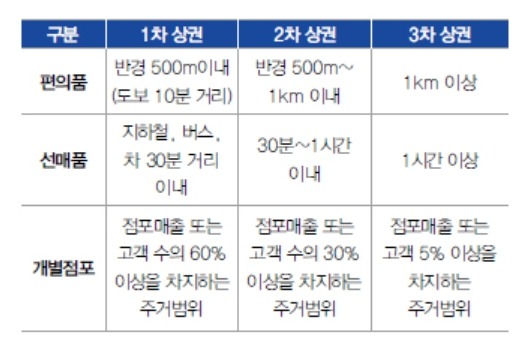

In [14]:
Image("./상권거리.jpg")

In [22]:
m = folium.Map(
    location=[35.137922, 129.055628],
    zoom_start=15, 
    tiles='OpenStreetMap',
    zoom_control = True
)

folium.GeoJson(
    busan_geo,
    name='지역명'
).add_to(m)

# 우측 하단 미니맵 표시
minimap = folium.plugins.MiniMap()
m.add_child(minimap)

# 부산시 주요 관광지 위치 및 반경
attractions = list(zip(df_busan_attraction["LAT"], df_busan_attraction["LNG"], df_busan_attraction["MAIN_TITLE"]))

# 상권 반경은 500m로 설정
for i in range(len(attractions)):
    folium.Circle(location=attractions[i][:2],
                  tooltip=attractions[i][2],
                  radius=500,
                  color="#2a9d8f",
                  fill=True,
                  fill_color="#2a9d8f"
                 ).add_to(m)

for i in range(len(attractions)):
    folium.Circle(location=attractions[i][:2],
                  radius=1,
                  color="#2a9d8f"
                 ).add_to(m)

# 부산시 지역화폐가맹점 표시(너무 많은 관계로 1만개만 표시)
shops = list(zip(df_shop["위도"], df_shop["경도"]))[:10000]


# cluster = folium.plugins.MarkerCluster(locations=locations)
# m.add_child(cluster)

for i in range(len(shops[:10000])):
    folium.CircleMarker(location=shops[i],radius=2, color = '#FF7467').add_to(m)

m